# IFT6390 Project - Data Exploration snippets

## Useful piece of code

## Setup - data

In [13]:
print(__doc__)

!pip install keras
!{sys.executable} -m pip install scikit-plot

import keras
import scikitplot as skplt

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import sys


#Natural Language Toolkit
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#identifies words which are not adding semantic value to the sentence
stopw = set(stopwords.words('english'))

Automatically created module for IPython interactive environment
     |████████████████████████████████| 378kB 1.3MB/s eta 0:00:01


Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /home/rd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import cleaned dataframe

In [155]:
a=datetime.datetime.now()

s140=pd.read_pickle('data/s140_clean_28nov.pkl')
mr=pd.read_pickle('data/mr_clean_28nov.pkl')
cc=pd.read_pickle('data/cc_clean_28nov.pkl')

print(datetime.datetime.now()-a)

0:00:06.579116


In [184]:
s140.target

0          -1
1          -1
2          -1
3          -1
4          -1
           ..
1600493     1
1600494     1
1600495     1
1600496     1
1600497     1
Name: target, Length: 1600498, dtype: object

In [185]:
print('NaN before replace: ', cc.target.isna().sum())
cc=cc.replace({'target': {np.nan: 'Not Sure'}})
print('NaN after replace: ', cc.target.isna().sum())

def nnlabel(df):
    return df.replace({'target': {'positive':1,'Not Sure':0,'neutral':0,'negative':2}})

cc=nnlabel(cc)
mr=nnlabel(mr)
s140=nnlabel(s140)

NaN before replace:  0
NaN after replace:  0


In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def make_tfidf(df):
    tf_vect=TfidfVectorizer(use_idf=False,stop_words=stopw)
    tf=tf_vect.fit_transform(df.tolist())
    
    l=tf.shape[0]
    
    w_count=np.array(tf.sum(axis=0,))[0]/l
    #wcm=w_count.max()
    #w_count=w_count/wcm
    wcr=w_count.argsort()[::-1].argsort()

    
    idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
    idf=idf_vect.fit_transform(df.tolist())
    
    w_marker=np.array(idf.sum(axis=0))[0]/l
    #wmm=w_marker.max()
    #w_marker=w_marker/wmm
    wmr=w_marker.argsort()[::-1].argsort()
    
    
    # SRC -> https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
    feature_names=tf_vect.get_feature_names()
    
    tf_idf = pd.DataFrame(np.array([w_count, w_marker, wcr, wmr]).T, index=feature_names, columns=["tf", "idf", "rank_tf", "rank_idf"])
    tf_idf = tf_idf.sort_values(by=["tf"],ascending=False)

    tf_idf.rank_tf=tf_idf.rank_tf.astype('int64')
    tf_idf.rank_idf=tf_idf.rank_idf.astype('int64')

    return tf_idf


## Transform s140

In [6]:
#all=make_tfidf(s140['trimmed'])

In [158]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
s140_tf_idf=tf_idf_vect.fit_transform(s140['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:29.179505


## Transform MR

In [159]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
mr_tf_idf=tf_idf_vect.fit_transform(mr['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:07.134736


## Transform CC

In [160]:
a=datetime.datetime.now()

tf_idf_vect=TfidfVectorizer(use_idf=True,stop_words=stopw)
cc_tf_idf=tf_idf_vect.fit_transform(cc['trimmed'].tolist())

print(datetime.datetime.now()-a)

0:00:00.145637


## Model testing

In [176]:
#import scikitplot as skplt
#import scikitplot#.plotters as skplt

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#The mean score and the 95% confidence interval of the score estimate are hence given by:

def crossval(model, x, y):    
    scores = cross_val_score(model, x, y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

def confusion(y_valid,predicted):
    if len(y_valid.shape)!=1 or len(predicted.shape)!=1:
        y_v=np.argmax(y_valid,axis=1)
        pred=np.argmax(predicted,axis=1)
    skplt.metrics.plot_confusion_matrix(y_v, pred,x_tick_rotation=90,figsize=(3,6))#, normalize=True)
    plt.show()  
    
def TryModel(model, xt, yt,xv=0,yv=0, selfie=True):  
    if selfie:
        X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)
    else:
        X_train, X_valid, y_train, y_valid=xt,xv,yt,yv

    clf = model.fit(X_train, y_train)

    predicted = clf.predict(X_valid)

    acc=accuracy_score(y_valid, predicted)
    print(f"Accuracy: {acc}")

    confusion(y_valid,predicted)

    return y_valid,predicted


from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

## Data
#data = np.random.random((1000,100))
#labels = np.random.randint(2,size=(1000,1))

class nn:
    def __init__(self):
        pass
        
    def train(x,y,epoch=1,layers=16):
        # Define network (model)
        nn.model = Sequential() 

        nn.y = to_categorical(y,3)
        nn.model.add(Dense(layers, activation='relu', input_dim=x.shape[1]))
        nn.model.add(Dense(nn.y.shape[1], activation='sigmoid'))

        # Configure training
        nn.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        # Fit model by training
        nn.model.fit(x,nn.y,epochs=epoch,batch_size=32)
        
    def predict(x_test):
        # Make predictions
        return nn.y,nn.model.predict(x_test)
    
    def eval(x,y):
        test_loss, test_acc = network.evaluate(x,y)
        return test_loss, test_acc

## Trained and tested on the same dataset (selfie)

### mr

Epoch 1/1
50000/50000 [==============================] - 91s 2ms/step - loss: 0.4392 - accuracy: 0.8625


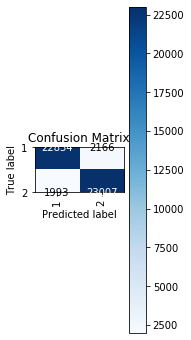

In [171]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

mrNN=nn
mrNN.train(x, y)
mr_y,mr_pred=mrNN.predict(x)
confusion(mr_y,mr_pred)

#print(datetime.datetime.now()-a)

### cc

Epoch 1/5
6027/6027 [==============================] - 3s 572us/step - loss: 1.0211 - accuracy: 0.5125
Epoch 2/5
6027/6027 [==============================] - 3s 480us/step - loss: 0.9161 - accuracy: 0.5323
Epoch 3/5
6027/6027 [==============================] - 3s 459us/step - loss: 0.8236 - accuracy: 0.5902
Epoch 4/5
6027/6027 [==============================] - 3s 460us/step - loss: 0.7331 - accuracy: 0.6753
Epoch 5/5
6027/6027 [==============================] - 3s 420us/step - loss: 0.6554 - accuracy: 0.7456


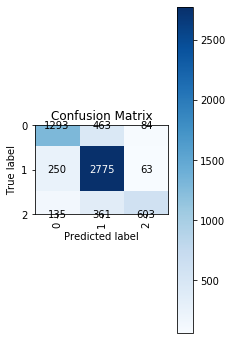

0:00:16.984275


In [177]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

ccNN=nn
ccNN.train(x, y, 5)
cc_y, cc_pred=ccNN.predict(x)
confusion(cc_y,cc_pred)

print(datetime.datetime.now()-a)

### s140

In [ ]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

s140NN=nn
s140NN.train(x, y)
s140_y,s140_pred=s140NN.predict(x)
confusion(s140_y,s140_pred)

print(datetime.datetime.now()-a)

Epoch 1/1
  43680/1600498 [..............................] - ETA: 3:43:39 - loss: 0.6751 - accuracy: 0.6745

# Cross-Trained

## NN Movies trained w S140

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=s140NN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN CC trained w S140

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

pred=s140NN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN Movies trained w CC

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=ccNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN CC trained w Movies

In [ ]:
a=datetime.datetime.now()

#x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
x,y = cc_tf_idf, cc['target']

pred=mrNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w CC

In [ ]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=ccNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

## NN s140 trained w Movies

In [ ]:
a=datetime.datetime.now()

x,y = s140_tf_idf, s140['target']
#x,y = mr_tf_idf, mr['target']
#x,y = cc_tf_idf, cc['target']

pred=mrNN.predict(x)
confusion(y,pred)

print(datetime.datetime.now()-a)

In [109]:
y123=np.argmax(pred,axis=1)
y123[y123!=0]
pred

array([[779., 779.],
       [779., 779.],
       [779., 779.],
       ...,
       [779., 779.],
       [779., 779.],
       [779., 779.]], dtype=float32)